In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `/Volumes/Chenyi/MIT/mosquito_inference/MosquitoProject`


In [2]:
using MosquitoProject
using DelimitedFiles,LinearAlgebra,
      StatsBase, DifferentialEquations, Plots

default(grid=false,legend=false, size=(400,320), 
        dpi=300, tickfontsize=16, lw=2, labelfontsize=16, tickdir=:out, fontfamily="Arial", legendfontsize=13)

[ Info: Precompiling MosquitoProject [81638d68-bacb-4361-b6cc-f3b1695bb2fa]


### Define custom mosquito model

In [3]:
# define ODE equations
function define_rhs!(du, u, t, 
                  ndim::Int, vel::Vector{T}, pos::Vector{T}, bvec::Vector{T}, uvec::Vector{T},
                  bfields; alpha=1.0, beta=5.0) where T
    
    fill!(du, 0.0)
    fill!(pos, 0.0)
    fill!(vel, 0.0)
    

    # dx/dt = v
    for k = 1:ndim
        du[k]=u[ndim + k]
    end
    
    # vel <- v
    for k=1:ndim
        pos[k] = u[k]
        vel[k] = u[ndim+k]
    end

    # a field
    vmag = mynorm(vel)
    vel ./= vmag
        
    # compute b 
    fill!(bvec, 0.0)
    bmag = bfields(bvec, pos)

    # compute a dot b
    ab_dot = 0.0;
    for k in 1:ndim
        ab_dot += vel[k] * bvec[k];
    end
    
    copy!(uvec, bvec)
    
    fmag = alpha * vmag / bmag / (1 + exp(beta*ab_dot))
    
    for k in 1:ndim
        du[ndim+k] =  fmag * uvec[k]
    end
    
    nothing
end

define_rhs!(du, u, M::MosquitoModel, t) = define_rhs!(du, u, t, 
                                       M.ndim, M.velocity, M.position, M.bvec, M.uvec,
                                       M.bfields[:visual]);


function define_sde_prob2(model::M; u0=zeros(2*model.ndim), tspan=(0.0, 1.0)) where M <: ODEModels
    prob = SDEProblem(define_rhs!, get_w!, u0, tspan, model);
    return prob
end


function sde_sim2(model::M, u0::Vector{Vector{T1}}, tspan::Vector{Tuple{T2, T3}}, solver=EM();
                      dts=0.01, ode_args...) where {M <: ODEModels, T1 <: Number, T2 <: Number, T3 <: Number}
    
    (length(u0) != length(tspan)) && (error("DimensionError: dimensions of u0 and tspan don't match"))
    
    prob = define_sde_prob2(model);
    
    rarray = Vector{Matrix{Float64}}(undef, length(u0))
    varray = Vector{Matrix{Float64}}(undef, length(u0))
    tarray = Vector{Array{Float64}}(undef, length(u0))
    
    for n = 1:length(u0)
        prob_n = remake( prob; tspan=tspan[n], u0=u0[n]);
        sol_n = solve(prob_n, solver; saveat=dts, tstops=collect(prob_n.tspan[1]:dts:prob_n.tspan[2]), ode_args...)
        cache_sol = Array(sol_n');
        tmax = floor( Int, (sol_n.t[end] - sol_n.t[1]) / dts ) + 1
        rarray[n] = cache_sol[1:tmax,1:model.ndim];
        varray[n] = cache_sol[1:tmax,(model.ndim+1):(2*model.ndim)];
        tarray[n] = sol_n.t[1:tmax]
    end

    return tarray, rarray, varray
end


function distance_to_center_pbc!(v, r; L=3)
    for k in 1:length(r)
        v[k] = mod(r[k] + L, 2*L) - L
    end
    dd = mynorm(v)
    v ./= dd
    return dd
end

distance_to_center_pbc! (generic function with 1 method)

In [4]:
function define_model_true(; ndim=2, f1=LaguerreFunction{Float64}(), n1=collect(0:5), p1=ones(1), c1=zeros(length(n1)), bfield1=nullfunc!,
                        f2a=LaguerreFunction{Float64}(), f2b=LaguerreFunction{Float64}(), f2ab=LegendreP{Float64}(),
                        n2a=collect(0:5), n2b=collect(0:5), n2ab=collect(0:5), c2=zeros(length(n2a)*length(n2b)*length(n2ab)),
                        p2=ones(2), bfield2=nullfunc!, D=0.0)
    
    model=MosquitoModel(; ndim=ndim, f1=f1, f2a=f2a, f2b=f2b, f2ab=f2ab);

    model.islearned[:visual] = true
    model.bfields[:visual] = bfield2
    model.diffD = D
    
    return model

end

function sample_init(; v₀ = 1.0, σᵥ = 0.2 )
    ρ =  sqrt(rand())
#     v =  v₀ + σᵥ * randn()
    v = rand()*1.0
    
    x1, y1=  randn(), randn()
    n1 = sqrt(x1^2 + y1^2)
    x1 /= n1
    y1 /= n1
#     z1 /= n1
    
    x2, y2=  randn(), randn()
    n2 = sqrt(x2^2 + y2^2)
    x2 /= n2
    y2 /= n2
#     z2 /= n2
    
    return [ρ*x1, ρ*y1,v*x2, v*y2]
end

function pbc_mapping(r; L=3)
    return mod(r + L, 2*L) - L
end

pbc_mapping (generic function with 1 method)

In [15]:
# generate N trajectories as input data
N = 500
u0s = [sample_init() for _ in 1:N]
Ts = [(0.0, 10.0) for _ in 1:N]
model_true = define_model_true(;
                bfield2 = distance_to_center_pbc!, D=0.2);

dts=0.01;
solver=SOSRA();
simTs, simPos, simVel  = sde_sim2(model_true, u0s, Ts, solver; dts=dts);

In [16]:
# analyze speeds 
simSpeeds = [sqrt.(sum(abs2, simVel[i], dims=2)) for i in 1:N];

### Plot: input trajectories

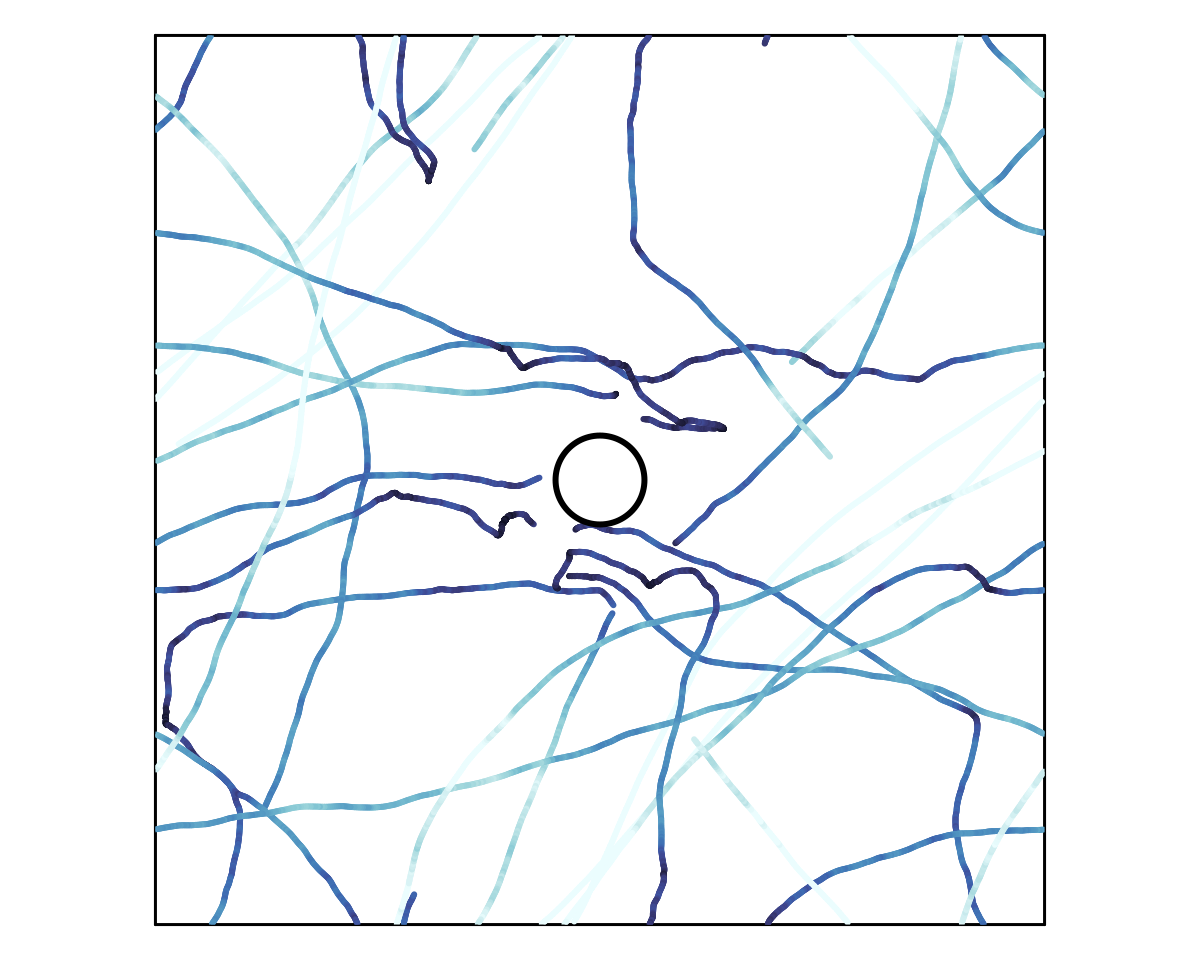

In [17]:
pp = plot(; framestyle=:box, background_color=:transparent, aspect_ratio=1, xlim=(-3,3), ylim=(-3,3), 
    xtick=[], ytick=[]);
for k in 1:50:N
    breaks = findall( (abs.(diff(pbc_mapping.(simPos[k][:,1]))) .> 1.0 ) .| (abs.(diff(pbc_mapping.(simPos[k][:,2]))) .> 1.0 ) )
    breaks = vcat([0], breaks, size(simPos[k],1))

    for i in 1:(length(breaks)-1)
        plot!(pp, pbc_mapping.(simPos[k][(breaks[i]+1):breaks[i+1],1]), 
                  pbc_mapping.(simPos[k][(breaks[i]+1):breaks[i+1],2]), 
                  line_z = simSpeeds[k][(breaks[i]+1):breaks[i+1]], clim=(0,2), c=:ice)
    end
end
θ = collect(range(0,2π,101));
plot!(pp, 0.3*cos.(θ), 0.3*sin.(θ), lw=2, lc=:black)
pp

In [18]:
# define inference model
function define_model_learn(; ndim=3, f1=LaguerreFunction{Float64}(), n1=collect(0:5), p1=ones(1), c1=zeros(length(n1)), bfield1=nullfunc!,
                        f2a=LaguerreFunction{Float64}(), f2b=LaguerreFunction{Float64}(), f2ab=LegendreP{Float64}(),
                        n2a=collect(0:5), n2b=collect(0:5), n2ab=collect(0:5), c2=zeros(length(n2a)*length(n2b)*length(n2ab)),
                        p2=ones(2), bfield2=nullfunc! )
    
    model=MosquitoModel(; ndim=ndim, f1=f1, f2a=f2a, f2b=f2b, f2ab=f2ab);

    model.islearning[:visual] = true
    model.funcs[:visual] =  vcat( 
        [ vcat( 
                [ vcat(
                        [Ψ2(f2a, f2b, f2ab, n2a_, n2b_, n2ab_, :bhat) for n2ab_ in n2ab]...
                      )  for n2b_ in n2b]... 
              ) for n2a_ in n2a]... 
        )
    model.coeffs[:visual] = zeros(length(model.funcs[:visual]))
    model.params[:visual] = p2;
    model.bfields[:visual] = bfield2
    
    return model

end

f_basis = LaguerreFunction{Float64}();
g_basis = LegendreP{Float64}();
model_learn = define_model_learn(; ndim=2, f2a=f_basis, f2b=f_basis, f2ab=g_basis, n2a=collect(0:1), n2b=collect(0:3), n2ab=collect(0:5),
                       bfield2 = distance_to_center_pbc!);

In [19]:
function inference_pipeline(x, v, t, model; force_type=:visual, cutoff=0.05, dts=0.01)
    
    P = MosquitoInference(x, v, t, model);
    init_mosquitoinference(P);
    res = sparse_bayesian_fit(P, [1.0, 1.0], force_type; MAX_ITERS=100)
    
    D_learn = 0.0
    count = 1
    cov = zeros(size(P.G)[2],size(P.G)[2])
    while true
        coeffs_old = copy(P.coef_full);
        res_this = SBLvar( P.G[:, P.bigind], P.b, MAX_ITERS=100);
        fill!(P.coef_full, 0.0)
        copy!(@view(P.coef_full[P.bigind]), res_this[2])
        P.bigind = abs.(P.coef_full) .> cutoff;
        P.coef_full[.!(P.bigind)] .= 0.0;
        cov = res_this[3]
        D_learn = exp(2*res_this[1])*dts
        println("itr=$count: n=$(sum(P.bigind)), D=$(exp(2*res_this[1])*dts)")
        count += 1
        if maximum(abs.(P.coef_full .- coeffs_old)) < 1e-6 || sum(P.bigind) == 0
            break
        end
    end
    
    model.coeffs[force_type] = P.coef_full;
    model.islearned[force_type] = true
    model.diffD = D_learn;
    
    nothing
end

inference_pipeline (generic function with 1 method)

In [20]:
inference_pipeline(simPos, simVel, simTs, model_learn);

itr=1: n=18, D=0.1997218540941696
itr=2: n=18, D=0.1997223382870088
itr=3: n=18, D=0.1997223382870088


In [21]:
function fmag_true(vdotd, d; v=0.4, alpha=1.0, beta=5.0)
    return alpha * v ./ d ./ (1 .+ exp.(beta*vdotd))
end

function fmag_learn(funcs, params, coeffs, vmag, dd, vd)
    f = 0.0
    for idx in eachindex(funcs)
        # fmag
        (typeof(funcs[idx])<:Ψ1) && ( fmag = term_mag(funcs[idx], vmag, params[1]))
        (typeof(funcs[idx])<:Ψ2) && ( fmag = term_mag(funcs[idx], vmag, dd, vd, params[1], params[2]) ) 
        f += coeffs[idx] * fmag
    end
    return f
end

fmag_learn (generic function with 1 method)

In [22]:
d_array = collect(0.5:0.01:2)
vdotd_array = collect(-1:0.01:1)
v_array = collect(0:0.01:1.5);

f_true = [fmag_true(_vdotd, _d; v=_v) for _d in d_array, _vdotd in vdotd_array, _v in v_array];
f_learn = [ fmag_learn(model_learn.funcs[:visual], model_learn.params[:visual], model_learn.coeffs[:visual], _v, _d, _vdotd) 
           for _d in d_array, _vdotd in vdotd_array, _v in v_array];

### Plot: learned vs true forces

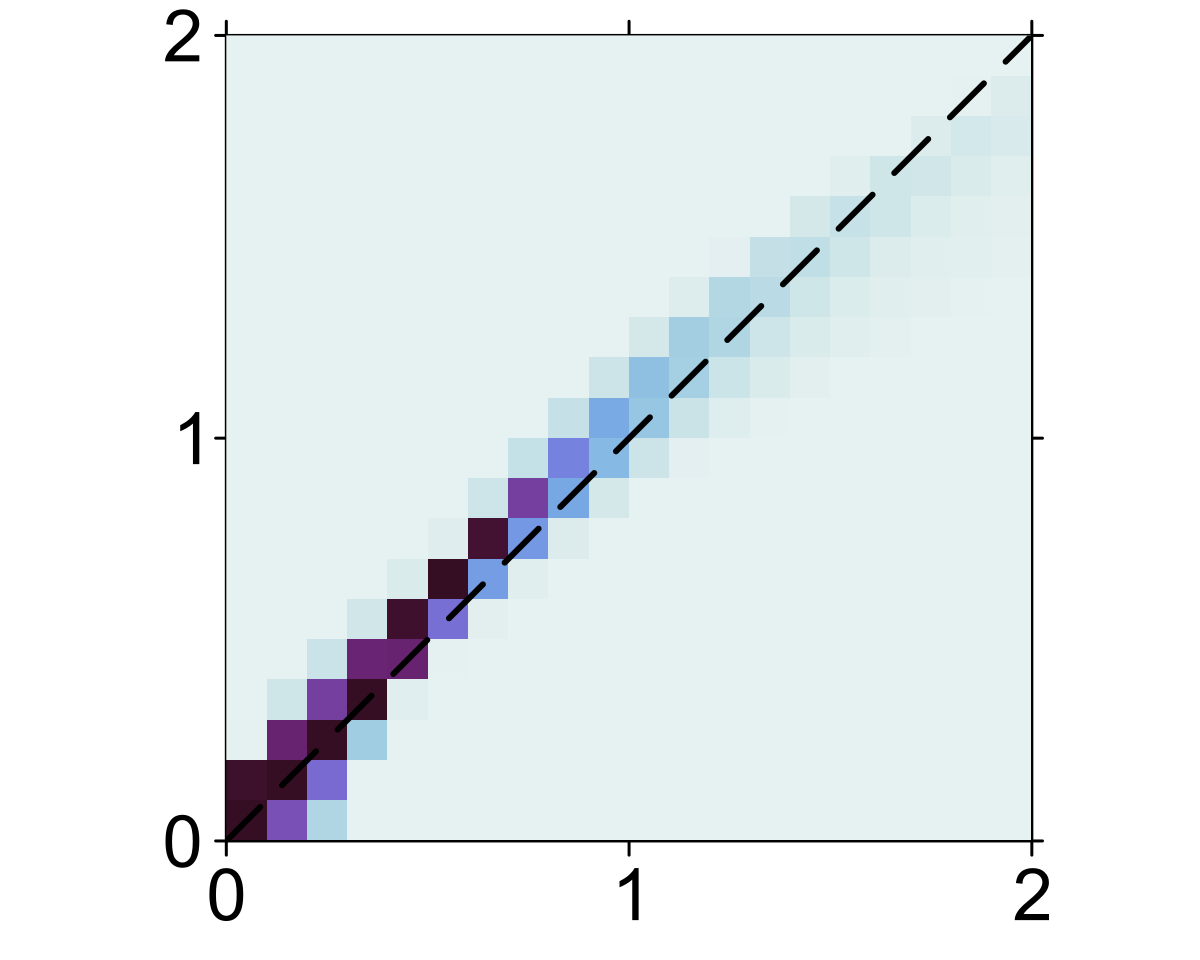

In [29]:
histogram2d(f_true[:], f_learn[:], show_empty_bins=true, c=:dense, normalize=:pdf, clim=(0,4), 
            bins=(collect(0:0.1:2), collect(0:0.1:2)), framestyle=:box, aspect_ratio=1, xlim=(0,2), ylim=(0,2))
plot!([0,2],[0,2],lc=:black,ls=:dash, lw=2, xtick=[0,1,2], ytick=[0,1,2], dpi=300)
current()

### Plot: learned vs true forces (specific v)

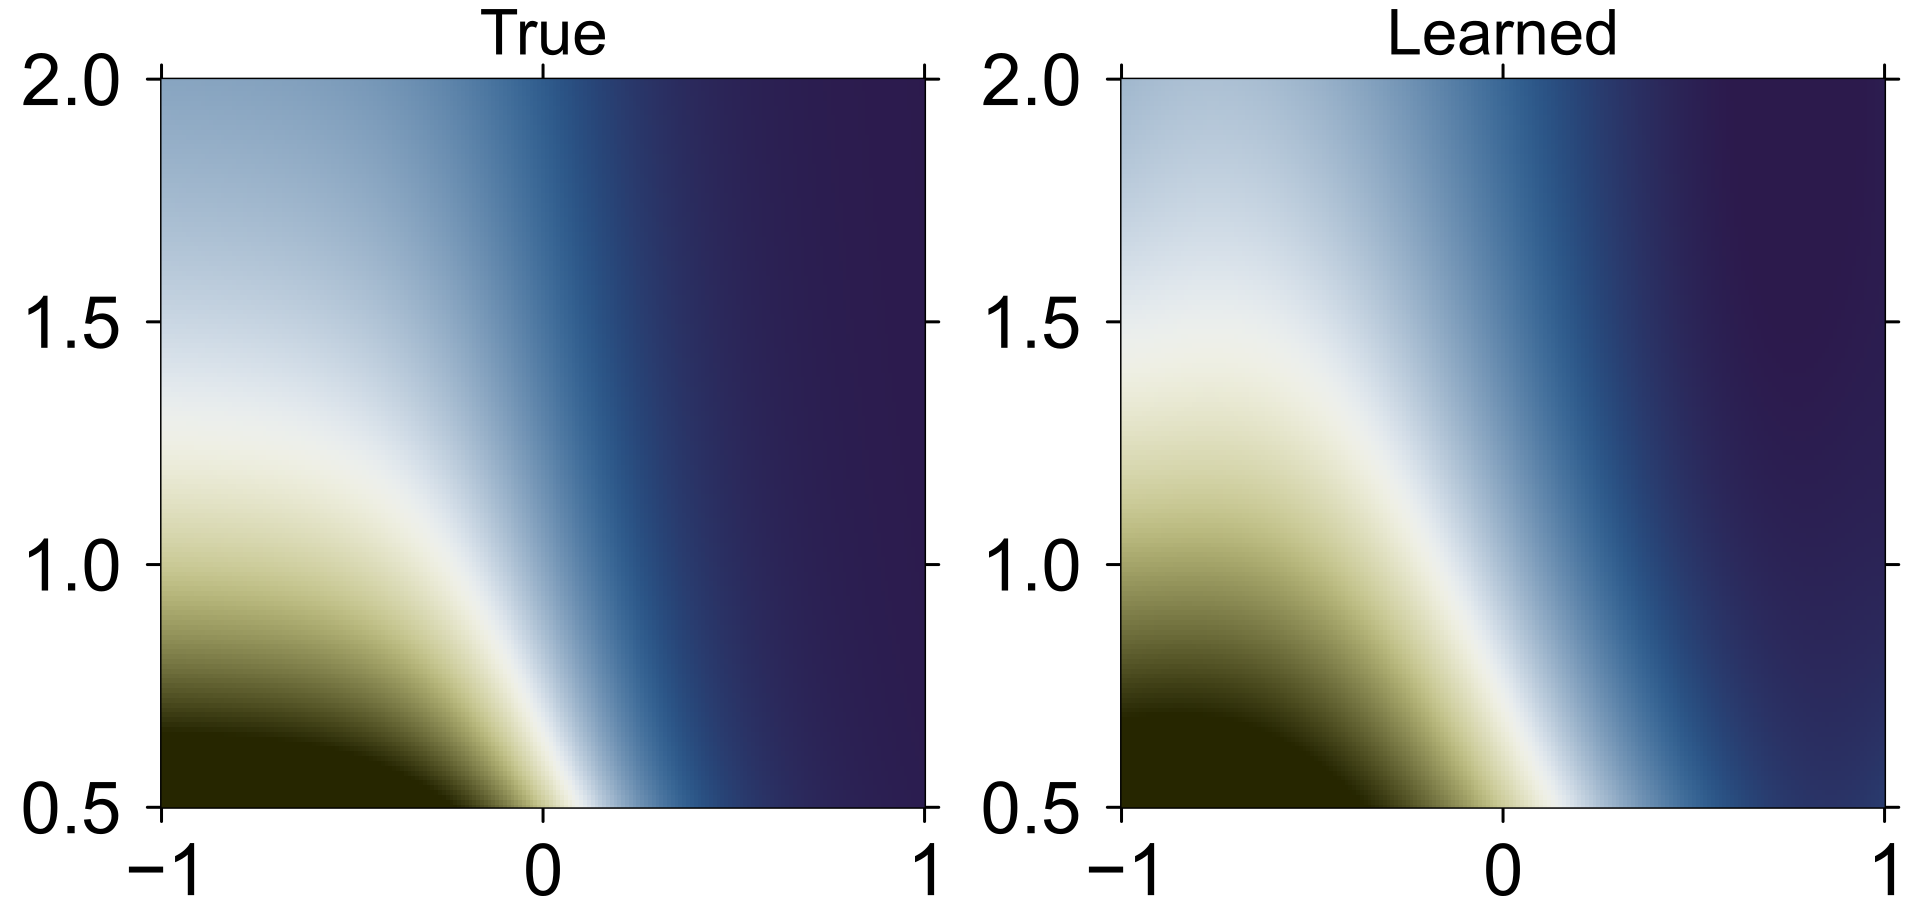

In [38]:
p1 = heatmap( vdotd_array, d_array, f_true[:,:,100], clim=(0,1.5), framestyle=:box, xlim=(-1,1), ylim=(0.5, 2), size=(320,300),
xtick=[-1, 0, 1], c=:broc, dpi=300,title="True")
p2 = heatmap( vdotd_array, d_array, f_learn[:,:,100], clim=(0,1.5), framestyle=:box, xlim=(-1,1), ylim=(0.5, 2), size=(320,300),
xtick=[-1, 0, 1], c=:broc, dpi=300, title="Learned")
plot(p1, p2, layout=(1,2), size=(640, 300))